## Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Load Dataset

#### Load of the CSV Data
- CSV Data: CSV Files for 17 countries
- Dollarstreet data is excluded because it is across more countries.

In [3]:
import pandas as pd
from scipy.spatial import distance
import ast

# List all files in the directory
directory = "/home/vsl333/cultural_values/notebooks/outputs"
# exclude file ending with _peoplle_results.csv
files = [f for f in os.listdir(directory) if f.endswith('.csv') and not f.endswith('_results.csv')]
print(len(files))


0


#### Compute JSD and Similarity for Countries (across all categories)
- JSD: Jensen Shannon Divergence
- Similarity is computed as 1 - JSD

In [186]:
results = []

for f in files:
    data = pd.read_csv(os.path.join(directory, f))

    # Add category column to the DataFrame
    data['category'] = data['image_path'].apply(lambda x: x.split('/')[-1].split('.')[0].split('_')[1:-2])
    data['category'] = data['category'].apply(lambda x: '_'.join(x))

    # Example gt and pred (list of lists)
    gt = [ast.literal_eval(x) for x in data['selection_answers'].tolist()] # there are prob distrbutions of human answers
    pred = [ast.literal_eval(x) for x in data['prob_percent_values'].tolist()] # there are prob distrbutions of model answers

    # Original DataFrame, retaining all columns from `data`
    df = data.copy()

    # Keep track of matching indices
    matching_indices = [i for i, (g, p) in enumerate(zip(gt, pred)) if len(g) == len(p)]

    # Filter rows where len(g) == len(p)
    filtered_gt_pred = [(g, p) for g, p in zip(gt, pred) if len(g) == len(p)]

    # If there are any matching rows
    if filtered_gt_pred:
        gt_filtered, pred_filtered = zip(*filtered_gt_pred)

        # Calculate JSD
        jsd = [distance.jensenshannon(g, p) for g, p in zip(gt_filtered, pred_filtered)]
        similarity = [1 - value for value in jsd]

        # Add JSD and similarity values back to the DataFrame
        df.loc[matching_indices, 'jsd'] = jsd
        df.loc[matching_indices, 'similarity'] = similarity
    else:
        df['jsd'] = None  # or handle the case accordingly
        df['similarity'] = None

    # Set JSD and similarity to NaN or a placeholder for rows that were filtered out
    df['jsd'] = pd.to_numeric(df['jsd'], errors='coerce')
    df['similarity'] = pd.to_numeric(df['similarity'], errors='coerce')

    # Calculate mean of jsd and similarity per country
    mean_per_country = df.groupby('country')[['jsd', 'similarity']].mean().reset_index()

    # Append results to list
    results.append(mean_per_country)

# Combine all results into a single DataFrame
final_result = pd.concat(results, ignore_index=True)

#### Sort countries in order of income (High Income to Low Income)

In [187]:
rich_countries = ["Russia", "Romania", "France", "Spain", "South Korea"]
medium_countries = ["Brazil", "Indonesia", "Mexico", "Philippines", "Mongolia", "China", "Colombia"]
poor_countries = ["Ethiopia", "Nigeria", "Egypt", "Kenya", "Pakistan"]


country_order= rich_countries + medium_countries + poor_countries 
print(len(country_order))
# sort final result by country_order and put it in a new dataframe
final_result_sorted = final_result.set_index('country').loc[country_order].reset_index()
final_result_sorted

17


,country,jsd,similarity
0,Russia,0.417080,0.582920
1,Romania,0.391510,0.608490
2,France,0.415819,0.584181
3,Spain,0.412742,0.587258
4,South Korea,0.500548,0.499452
5,Brazil,0.418051,0.581949
6,Indonesia,0.490806,0.509194
7,Mexico,0.416823,0.583177
8,Philippines,0.511297,0.488703
9,Mongolia,0.451727,0.548273


### Set the color palette for Countries Mapped to Income Level

In [188]:
country_mapping = {}
for country in rich_countries:
    country_mapping[country] = 'rich'
for country in medium_countries:
    country_mapping[country] = 'medium'
for country in poor_countries:
    country_mapping[country] = 'poor'

# Define a color palette for the categories
# Define a color palette for the categories
category_palette = {
    'rich': 'darkgreen',
    'medium': 'lightgreen',
    'poor': 'lightcoral'
}

# Map each country to its respective category
final_result_sorted['country_group'] = final_result_sorted['country'].map(country_mapping)
# Map colors based on the category_group
final_result_sorted['income_color'] = final_result_sorted['country_group'].map(category_palette)
final_result_sorted


,country,jsd,similarity,country_group,income_color
0,Russia,0.417080,0.582920,rich,darkgreen
1,Romania,0.391510,0.608490,rich,darkgreen
2,France,0.415819,0.584181,rich,darkgreen
3,Spain,0.412742,0.587258,rich,darkgreen
4,South Korea,0.500548,0.499452,rich,darkgreen
5,Brazil,0.418051,0.581949,medium,lightgreen
6,Indonesia,0.490806,0.509194,medium,lightgreen
7,Mexico,0.416823,0.583177,medium,lightgreen
8,Philippines,0.511297,0.488703,medium,lightgreen
9,Mongolia,0.451727,0.548273,medium,lightgreen


### Set the color palette for Countries Mapped to Region

In [189]:
country_regions = {"Russia": "Europe", "Romania": "Europe", "France": "Europe", "Spain": "Europe", "South Korea": "Asia",
                "Brazil": "South America", "Indonesia": "Asia", "Mexico": "North America", "Philippines": "Asia",
                "Mongolia": "Asia", "China": "Asia", "Colombia": "South America", "Ethiopia": "Africa",
                "Nigeria": "Africa", "Egypt": "Africa", "Kenya": "Africa", "Pakistan": "Asia"}

final_result_sorted['region'] = final_result_sorted['country'].map(country_regions)

region_palette = {
    'Europe': 'yellowgreen',
    'Asia': 'orangered',
    'Africa': 'darkseagreen',
    'North America': 'turquoise',
    'South America': 'paleturquoise'
}

final_result_sorted['region_color'] = final_result_sorted['region'].map(region_palette)
final_result_sorted

,country,jsd,similarity,country_group,income_color,region,region_color
0,Russia,0.417080,0.582920,rich,darkgreen,Europe,yellowgreen
1,Romania,0.391510,0.608490,rich,darkgreen,Europe,yellowgreen
2,France,0.415819,0.584181,rich,darkgreen,Europe,yellowgreen
3,Spain,0.412742,0.587258,rich,darkgreen,Europe,yellowgreen
4,South Korea,0.500548,0.499452,rich,darkgreen,Asia,orangered
5,Brazil,0.418051,0.581949,medium,lightgreen,South America,paleturquoise
6,Indonesia,0.490806,0.509194,medium,lightgreen,Asia,orangered
7,Mexico,0.416823,0.583177,medium,lightgreen,North America,turquoise
8,Philippines,0.511297,0.488703,medium,lightgreen,Asia,orangered
9,Mongolia,0.451727,0.548273,medium,lightgreen,Asia,orangered


## Plot the Heatmap for Similarity
- This is plotted for each country (across all categories)
- Similarity = 1 - JSD
- Origin: Mean Similarity across all countries
- Distance Per Country = Similarity Score Per Country - Origin (Mean Similarity Score) 
- Higher Similarity Distance = Closer to Human Distriubtion

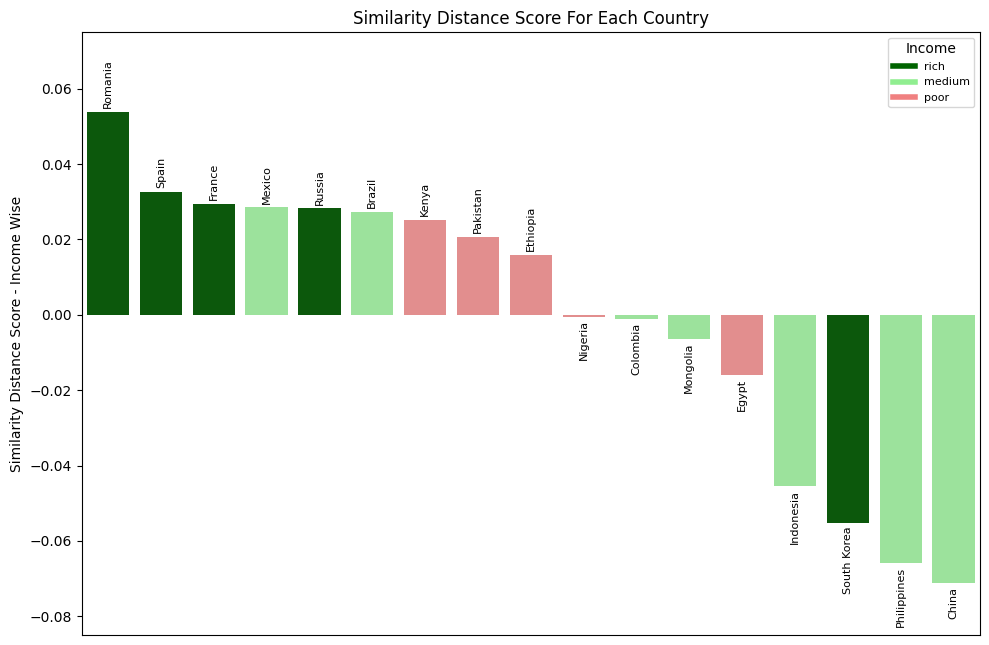

In [194]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))

# Calculate the mean similarity value
origin = final_result_sorted['similarity'].mean()

# Sort data based on similarity
final_result_sorted = final_result_sorted.sort_values(by='similarity', ascending=False)

# Calculate deviation from the mean (center the bars at the mean similarity)
final_result_sorted['similarity_centered'] = final_result_sorted['similarity'] - origin

mapped_dict = dict(zip(final_result_sorted['country'], final_result_sorted['income_color']))

# Plot vertical bar chart centered on the mean similarity
bars = sns.barplot(
    x='country',
    y='similarity_centered',
    data=final_result_sorted,
    palette=mapped_dict
)

# Add a horizontal line for the centered mean (origin)
# plt.axhline(0, color='blue', linestyle='--', label=f'Mean similarity = {origin:.2f}')

# Set the y-axis limits to highlight the range
plt.ylim(-0.085, 0.075)

# Remove x-axis labels
plt.xticks([])

# Add labels and title
plt.ylabel('Similarity Distance Score - Income Wise')
plt.xlabel('')  # Optionally, remove x-axis label as well
plt.title('Similarity Distance Score For Each Country')

# Display legend about color mapping. Top right corner. Label: income, color: color
# Display in a bo
# Create custom legend handles
legend_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in category_palette.values()]

plt.legend(
    handles=legend_handles,
    labels=[f'{key}' for key, value in category_palette.items()],
    title='Income',
    loc='upper right',
    fontsize=8
)

# Annotate bars with the country names
for bar, country in zip(bars.patches, final_result_sorted['country']):
    height = bar.get_height()
    # Place text slightly above the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + (0.001 if height >= 0 else -0.001),  # Adjust position based on height
        country,
        ha='center',
        va='bottom' if height >= 0 else 'top',  # Adjust alignment based on direction
        fontsize=8,
        rotation=90  # Rotate text for better readability
    )

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
# Show the plot
plt.show()


### Plot of Similarity Heatmap for each country (across all categories) - Region Wise

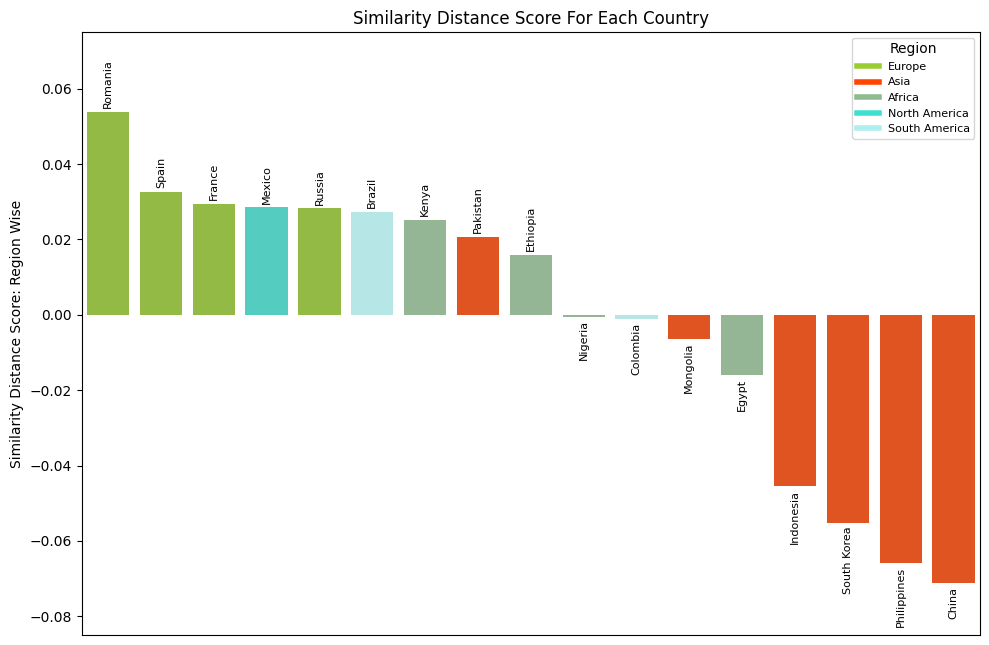

In [196]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))

# Calculate the mean similarity value
origin = final_result_sorted['similarity'].mean()

# Sort data based on similarity
final_result_sorted = final_result_sorted.sort_values(by='similarity', ascending=False)

# Calculate deviation from the mean (center the bars at the mean similarity)
final_result_sorted['similarity_centered'] = final_result_sorted['similarity'] - origin

mapped_dict = dict(zip(final_result_sorted['country'], final_result_sorted['region_color']))

# Plot vertical bar chart centered on the mean similarity
bars = sns.barplot(
    x='country',
    y='similarity_centered',
    data=final_result_sorted,
    palette=mapped_dict
)

# Add a horizontal line for the centered mean (origin)
# plt.axhline(0, color='blue', linestyle='--', label=f'Mean similarity = {origin:.2f}')

# Set the y-axis limits to highlight the range
plt.ylim(-0.085, 0.075)

# Remove x-axis labels
plt.xticks([])

# Add labels and title
plt.ylabel('Similarity Distance Score: Region Wise')
plt.xlabel('')  # Optionally, remove x-axis label as well
plt.title('Similarity Distance Score For Each Country')

# Display legend with color mapping. Top right corner. Label: region, color: color
# Display in a box
# Create custom legend handles
legend_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in region_palette.values()]

plt.legend(
    handles=legend_handles,
    labels=[f'{key}' for key, value in region_palette.items()],
    title='Region',
    loc='upper right',
    fontsize=8
)

# Annotate bars with the country names
for bar, country in zip(bars.patches, final_result_sorted['country']):
    height = bar.get_height()
    # Place text slightly above the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + (0.001 if height >= 0 else -0.001),  # Adjust position based on height
        country,
        ha='center',
        va='bottom' if height >= 0 else 'top',  # Adjust alignment based on direction
        fontsize=8,
        rotation=90  # Rotate text for better readability
    )

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
# Show the plot
plt.show()


### Plot For Normalized Similarity Distance

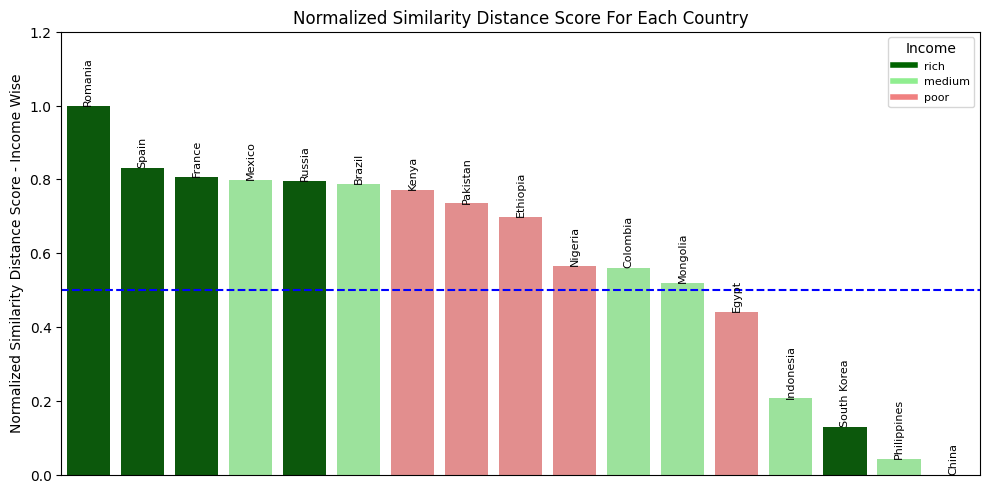

In [197]:
## Plot Normalzed Similarity Heatmap for each country

# import numpy as np
sim_values = final_result_sorted['similarity'].to_list()
min_sim = np.min(sim_values)
max_sim = np.max(sim_values)
rescaled_sim = [(sim - min_sim) / (max_sim - min_sim) for sim in sim_values]

final_result_sorted['rescaled_similarity'] = rescaled_sim

#---------------------------------------------------------------------------------
plt.figure(figsize=(10, 6))


# Sort data based on rescaled imilarity
final_result_sorted = final_result_sorted.sort_values(by='rescaled_similarity', ascending=False)

# Map colors based on the category_group
# mapped_palette = final_result_sorted['country_group'].map(final_result_sorted['income_color'])
mapped_dict = dict(zip(final_result_sorted['country'], final_result_sorted['income_color']))

# Plot vertical bar chart centered on the mean similarity
bars = sns.barplot(
    x='country',
    y='rescaled_similarity',
    data=final_result_sorted,
    palette=mapped_dict
)

# Add a horizontal line for the centered mean (origin)
plt.axhline(0.5, color='blue', linestyle='--', label=f'Normalized Similarity')

# Set the y-axis limits to highlight the range
plt.ylim(0, 1.2)

# Remove x-axis labels
plt.xticks([])

# Add labels and title
plt.ylabel('Normalized Similarity Distance Score - Income Wise')
plt.xlabel('')  # Optionally, remove x-axis label as well
plt.title('Normalized Similarity Distance Score For Each Country')

# Display legend about color mapping. Top right corner. Label: income, color: color
# Display in a bo
# Create custom legend handles
legend_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in category_palette.values()]

plt.legend(
    handles=legend_handles,
    labels=[f'{key}' for key, value in category_palette.items()],
    title='Income',
    loc='upper right',
    fontsize=8
)

# Annotate bars with the country names
for bar, country in zip(bars.patches, final_result_sorted['country']):
    height = bar.get_height()
    # Place text slightly above the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + (0.001 if height >= 0 else -0.001),  # Adjust position based on height
        country,
        ha='center',
        va='bottom' if height >= 0 else 'top',  # Adjust alignment based on direction
        fontsize=8,
        rotation=90  # Rotate text for better readability
    )

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
# Show the plot
plt.show()


### Plot for Normalized Similarity Distance region wise

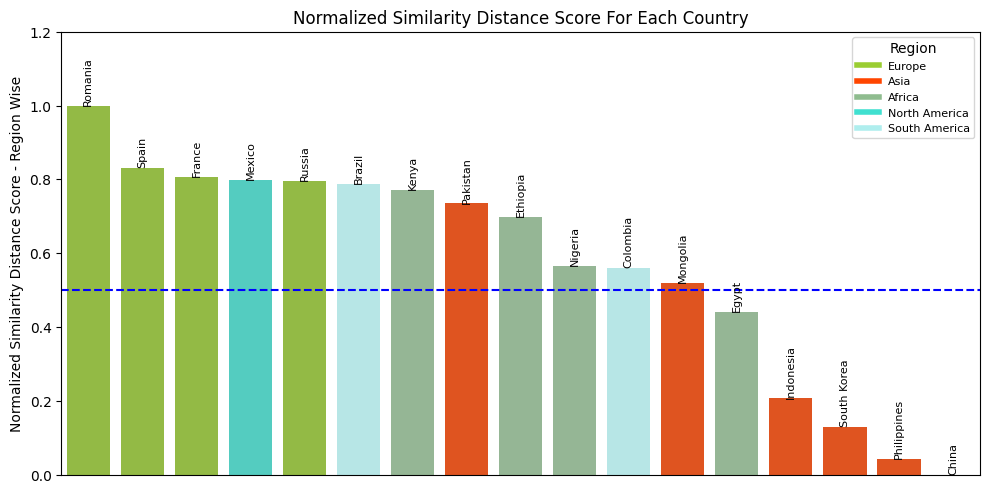

In [198]:
## Plot Normalzed Similarity Heatmap for each country

# import numpy as np
sim_values = final_result_sorted['similarity'].to_list()
min_sim = np.min(sim_values)
max_sim = np.max(sim_values)
rescaled_sim = [(sim - min_sim) / (max_sim - min_sim) for sim in sim_values]

final_result_sorted['rescaled_similarity'] = rescaled_sim

#---------------------------------------------------------------------------------
plt.figure(figsize=(10, 6))


# Sort data based on rescaled imilarity
final_result_sorted = final_result_sorted.sort_values(by='rescaled_similarity', ascending=False)

# Map colors based on the category_group
# mapped_palette = final_result_sorted['country_group'].map(final_result_sorted['region_color'])
mapped_dict = dict(zip(final_result_sorted['country'], final_result_sorted['region_color']))

# Plot vertical bar chart centered on the mean similarity
bars = sns.barplot(
    x='country',
    y='rescaled_similarity',
    data=final_result_sorted,
    palette=mapped_dict
)

# Add a horizontal line for the centered mean (origin)
plt.axhline(0.5, color='blue', linestyle='--', label=f'Normalized Similarity: 0.5')

# Set the y-axis limits to highlight the range
plt.ylim(0, 1.2)

# Remove x-axis labels
plt.xticks([])

# Add labels and title
plt.ylabel('Normalized Similarity Distance Score - Region Wise')
plt.xlabel('')  # Optionally, remove x-axis label as well
plt.title('Normalized Similarity Distance Score For Each Country')

# Display legend
# Display legend about color mapping. Top right corner. Label: region, color: color
# Display in a bo
# Create custom legend handles
legend_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in region_palette.values()]

plt.legend(
    handles=legend_handles,
    labels=[f'{key}' for key, value in region_palette.items()],
    title='Region',
    loc='upper right',
    fontsize=8
)

# Annotate bars with the country names
for bar, country in zip(bars.patches, final_result_sorted['country']):
    height = bar.get_height()
    # Place text slightly above the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + (0.001 if height >= 0 else -0.001),  # Adjust position based on height
        country,
        ha='center',
        va='bottom' if height >= 0 else 'top',  # Adjust alignment based on direction
        fontsize=8,
        rotation=90  # Rotate text for better readability
    )

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
# Show the plot
plt.show()


---------------------------------------

## Computer JSD, SIM Per Category Per Countries

In [199]:
results = []

for f in files:
    data = pd.read_csv(os.path.join(directory, f))

    # Add category column to the DataFrame
    data['category'] = data['image_path'].apply(lambda x: x.split('/')[-1].split('.')[0].split('_')[1:-2])
    data['category'] = data['category'].apply(lambda x: '_'.join(x))

    # Example gt and pred (list of lists)
    gt = [ast.literal_eval(x) for x in data['selection_answers'].tolist()]
    pred = [ast.literal_eval(x) for x in data['prob_percent_values'].tolist()]

    # Original DataFrame, retaining all columns from `data`
    df = data.copy()

    # Keep track of matching indices
    matching_indices = [i for i, (g, p) in enumerate(zip(gt, pred)) if len(g) == len(p)]

    # Filter rows where len(g) == len(p)
    filtered_gt_pred = [(g, p) for g, p in zip(gt, pred) if len(g) == len(p)]

    # If there are any matching rows
    if filtered_gt_pred:
        gt_filtered, pred_filtered = zip(*filtered_gt_pred)

        # Calculate JSD
        jsd = [distance.jensenshannon(g, p) for g, p in zip(gt_filtered, pred_filtered)]
        similarity = [1 - value for value in jsd]

        # Add JSD and similarity values back to the DataFrame
        df.loc[matching_indices, 'jsd'] = jsd
        df.loc[matching_indices, 'similarity'] = similarity
    else:
        df['jsd'] = None  # or handle the case accordingly
        df['similarity'] = None

    # Set JSD and similarity to NaN or a placeholder for rows that were filtered out
    df['jsd'] = pd.to_numeric(df['jsd'], errors='coerce')
    df['similarity'] = pd.to_numeric(df['similarity'], errors='coerce')

    # Calculate mean of jsd and similarity per country and per category
    mean_per_country_category = df.groupby(['country', 'category'])[['jsd', 'similarity']].mean().reset_index()

    # Append results to list
    results.append(mean_per_country_category)

# Combine all results into a single DataFrame
final_result = pd.concat(results, ignore_index=True)

In [200]:
final_result_sorted = final_result.set_index('country').loc[country_order].reset_index()
# Create a new column in the DataFrame for country category
final_result_sorted['category_group'] = final_result_sorted['country'].map(country_mapping)
final_result_sorted['category_color'] = final_result_sorted['category_group'].map(category_palette)

In [201]:
final_result_sorted['region'] = final_result_sorted['country'].map(country_regions)
final_result_sorted['region_color'] = final_result_sorted['region'].map(region_palette)

## Plot the Heatmap for Similarity for each category

In [202]:
income_dir = "income_category"
if not os.path.exists(income_dir):
    os.makedirs(income_dir)

# Plot similarity per category for all countries and save each plot
categories = final_result_sorted['category'].unique()

for category in categories:
    plt.figure(figsize=(12, 6))

    # Filter data for the current category (include all countries under this category)
    category_data = final_result_sorted[final_result_sorted['category'] == category]

    # # Drop NaNs in the similarity column
    # category_data = category_data.dropna(subset=['similarity'])

    # Sort data based on similarity for better visualization
    category_data = category_data.sort_values(by='similarity', ascending=False)

    # Calculate the mean similarity value for the current category across all countries
    origin = category_data['similarity'].mean()
    # print(f"origin: {origin}")

    # Calculate deviation from the mean (center the bars at the mean similarity)
    category_data['similarity_centered'] = category_data['similarity'] - origin

    # Map colors based on the category_group
    mapped_palette = category_data['category_group'].map(category_palette)

    # Ensure no missing values in the mapped palette
    if mapped_palette.isnull().any():
        print("Warning: Some category groups are not mapped to colors.")
        print(category_data[mapped_palette.isnull()])

    mapped_dict = dict(zip(category_data['country'], mapped_palette))
    # Plot vertical bar chart centered on the mean similarity
    bars = sns.barplot(
        x='country',
        y='similarity_centered',
        data=category_data,
        palette=mapped_dict
    )

    # Add a horizontal line for the centered mean (origin)
    plt.axhline(0, color='blue', linestyle='--', label=f'Mean similarity = {origin:.2f}')

    # Set the y-axis limits to highlight the range
    plt.ylim(-0.065, 0.065)

    # Remove x-axis labels
    plt.xticks([])

    # Add labels and title
    plt.ylabel('Similarity Deviation from Mean')
    plt.xlabel('Country')
    plt.title(f'Countries by Deviation in Similarity from the Mean for Category: {category}')

    # Display legend
    # Display legend about color mapping. Top right corner. Label: income, color: color
    # Display in a box
    # Create custom legend handles
    legend_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in category_palette.values()]

    plt.legend(
        handles=legend_handles,
        labels=[f'{key}' for key, value in category_palette.items()],
        title='Income',
        loc='upper right',
        fontsize=8
    )

    # Annotate bars with the country names
    for bar, country in zip(bars.patches, category_data['country']):
        height = bar.get_height()
        # Place text slightly above the bar
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + (0.01 if height >= 0 else -0.01),  # Adjust position based on height
            country,
            ha='center',
            va='bottom' if height >= 0 else 'top',  # Adjust alignment based on direction
            fontsize=6,
            rotation=90  # Rotate text for better readability
        )
    # Save the plot as a file
    plt.savefig(f'{income_dir}/{category}.png', bbox_inches='tight')
    print(f"Saved category: {category}")

    # Close the plot to free memory
    plt.close()

Saved category: Brands
Saved category: Cooking_and_food
Saved category: Geography
Saved category: Objects
Saved category: People_and_everyday_life
Saved category: Public_Figure_and_pop_culture
Saved category: Traditions
Saved category: Vehicles_and_Transportation
Saved category: Sports_and_recreation
Saved category: Plants_and_animal


### Plot of Similarity Heatmap for each category (across all countries) - Region Wise

In [203]:
region_dir = "regions_categories"
if not os.path.exists(region_dir):
    os.makedirs(region_dir)

# Plot similarity per category for all countries and save each plot
for category in categories:
    plt.figure(figsize=(12, 6))

    # Filter data for the current category (include all countries under this category)
    category_data = final_result_sorted[final_result_sorted['category'] == category]

    # # Drop NaNs in the similarity column
    # category_data = category_data.dropna(subset=['similarity'])

    # Sort data based on similarity for better visualization
    category_data = category_data.sort_values(by='similarity', ascending=False)

    # Calculate the mean similarity value for the current category across all countries
    origin = category_data['similarity'].mean()
    # print(f"origin: {origin}")

    # Calculate deviation from the mean (center the bars at the mean similarity)
    category_data['similarity_centered'] = category_data['similarity'] - origin

    # Map colors based on the category_group
    mapped_palette = category_data['region_color']

    # Ensure no missing values in the mapped palette
    if mapped_palette.isnull().any():
        print("Warning: Some category groups are not mapped to colors.")
        print(category_data[mapped_palette.isnull()])

    mapped_dict = dict(zip(category_data['country'], mapped_palette))
    # Plot vertical bar chart centered on the mean similarity
    bars = sns.barplot(
        x='country',
        y='similarity_centered',
        data=category_data,
        palette=mapped_dict
    )

    # Add a horizontal line for the centered mean (origin)
    # plt.axhline(0, color='blue', linestyle='--', label=f'Mean similarity = {origin:.2f}')

    # Set the y-axis limits to highlight the range
    plt.ylim(-0.065, 0.065)

    # Remove x-axis labels
    plt.xticks([])

    # Add labels and title
    plt.ylabel('Similarity Deviation from Mean')
    plt.xlabel('Country')
    plt.title(f'Countries by Deviation in Similarity from the Mean for Category: {category}')

    # Display legend
    # Display legend about color mapping. Top right corner. Label: region, color: color
    # Display in a box
    # Create custom legend handles
    legend_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in region_palette.values()]

    plt.legend(
        handles=legend_handles,
        labels=[f'{key}' for key, value in region_palette.items()],
        title='Region',
        loc='upper right',
        fontsize=8
    )

    # Annotate bars with the country names
    for bar, country in zip(bars.patches, category_data['country']):
        height = bar.get_height()
        # Place text slightly above the bar
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + (0.01 if height >= 0 else -0.01),  # Adjust position based on height
            country,
            ha='center',
            va='bottom' if height >= 0 else 'top',  # Adjust alignment based on direction
            fontsize=6,
            rotation=90  # Rotate text for better readability  
        )

    # Save the plot as a file
    plt.savefig(f'{region_dir}/similarity_per_category_{category}.png', bbox_inches='tight')
    print(f"Saved category: {category}")

    # Close the plot to free memory
    plt.close()

Saved category: Brands
Saved category: Cooking_and_food
Saved category: Geography
Saved category: Objects
Saved category: People_and_everyday_life
Saved category: Public_Figure_and_pop_culture
Saved category: Traditions
Saved category: Vehicles_and_Transportation
Saved category: Sports_and_recreation
Saved category: Plants_and_animal


-----------------------------------------------------------------------